In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchinfo import summary

import segmentation_models_pytorch as smp 

from torchvision.datasets import Cityscapes
from torchvision import transforms
import torchvision.models as models

c:\Users\zaits\anaconda3\envs\cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IGNORE_INDEX = 255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [IGNORE_INDEX, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes = len(valid_classes)
class_map

colors = [
    [0, 0, 0],
    [128, 64, 128],
    [244, 35, 232],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [0, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [3]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = IGNORE_INDEX
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

def decode_segmap(temp):
    #convert gray scale to color
    temp = temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [4]:
transform = A.Compose([
    A.Resize(256, 512),
    # A.RandomCrop(256, 256),
    A.HorizontalFlip(),
    A.ColorJitter(hue=0),
    A.Normalize(),
    ToTensorV2()])

class CityscapesDataset(Cityscapes):
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        smnt = Image.open(self.targets[index][0])

        if self.transforms is not None:
            transformed = self.transforms(image=np.array(img), mask=np.array(smnt))
            img = transformed['image']
            smnt = transformed['mask']
        smnt = encode_segmap(smnt)
        return img, smnt
        
# %%
train_dataset = CityscapesDataset('./data/cityscapes', split='train', mode='fine',
                                  target_type='semantic', transforms=transform)

val_dataset = CityscapesDataset('./data/cityscapes', split='val', mode='fine',
                                target_type='semantic', transforms=transform)

In [5]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)
        return x
    
# UNet model with ResNet backbone
class UNet(nn.Module):
    def __init__(self, out_channels, resnet_layers=34):
        super().__init__()
        
        # Load pre-trained ResNet model
        if resnet_layers == 18:
            resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT, )
        elif resnet_layers == 34:
            resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        else:
            raise ValueError("ResNet layers must be 18 or 34.")
        
        # Remove the fully connected layers and the average pooling layer from ResNet
        encoder = nn.Sequential(
            *list(resnet.children())[:-2]  # Exclude the final fully connected layer and avg pool
        )
        
        # Extract feature maps from specific layers of ResNet
        self.encoder_blocks = nn.ModuleList([
            nn.Sequential(*encoder[:3]), # Conv7x7 - BN - ReLU
            nn.Sequential(*encoder[3:5]), # MaxPool - ResNet L1
            encoder[5], # ResNet L2
            encoder[6], # ResNet L3
            encoder[7]]) # ResNet L4
        
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(512, 256, 256), # in, skip, out
            DecoderBlock(256, 128, 128),
            DecoderBlock(128, 64, 64),
            DecoderBlock(64, 64, 32),
            DecoderBlock(32, 0, 16)])
        
        self.segmentation_head = nn.Conv2d(16, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        encoder_outputs = []
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            encoder_outputs.append(x)

        skip_connections = encoder_outputs[-2::-1] + [None,] # remove the last one, reverse the rest, add None

        # Decoder
        for skip, decoder_block in zip(skip_connections, self.decoder_blocks):
            x = decoder_block(x, skip)

        # Segmentation head
        x = self.segmentation_head(x)

        return x

In [6]:
def get_smp_unet(out_channels, resnet_layers=34):
    return smp.Unet(encoder_name=f"resnet{resnet_layers}",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                    classes=out_channels,                      # model output channels (number of classes in your dataset)
                    )

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet(n_classes, resnet_layers=18)
# model = torch.load('./model.pt', weights_only=False)
#model = get_smp_unet(n_classes, resnet_layers=18)

print(summary(model, input_size=(16, 3, 256, 512)))

model = model.to(device)
model(torch.rand(1, 3, 256, 512, device=device)).size()

cuda
Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [16, 20, 256, 512]        --
├─ModuleList: 1-1                             --                        --
│    └─Sequential: 2-1                        [16, 64, 128, 256]        --
│    │    └─Conv2d: 3-1                       [16, 64, 128, 256]        9,408
│    │    └─BatchNorm2d: 3-2                  [16, 64, 128, 256]        128
│    │    └─ReLU: 3-3                         [16, 64, 128, 256]        --
│    └─Sequential: 2-2                        [16, 64, 64, 128]         --
│    │    └─MaxPool2d: 3-4                    [16, 64, 64, 128]         --
│    │    └─Sequential: 3-5                   [16, 64, 64, 128]         147,968
│    └─Sequential: 2-3                        [16, 128, 32, 64]         --
│    │    └─BasicBlock: 3-6                   [16, 128, 32, 64]         230,144
│    │    └─BasicBlock: 3-7                   [16, 128, 32, 64]         295,

torch.Size([1, 20, 256, 512])

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # Pred is of shape (batch_size, num_classes, height, width)
        # Target is of shape (batch_size, height, width) and contains class indices (not one-hot encoded)
        
        num_classes = pred.size(1)
        pred = F.softmax(pred, dim=1)  # Apply softmax to get class probabilities
        target_one_hot = F.one_hot(target.to(torch.int64), num_classes).permute(0, 3, 1, 2)  # Convert target to one-hot

        pred = pred.contiguous()
        target_one_hot = target_one_hot.contiguous()

        # Flatten
        pred_flat = pred.view(pred.size(0), pred.size(1), -1)
        target_flat = target_one_hot.view(target_one_hot.size(0), target_one_hot.size(1), -1)

        intersection = (pred_flat * target_flat).sum(2)
        dice_score = (2. * intersection + self.smooth) / (pred_flat.sum(2) + target_flat.sum(2) + self.smooth)
        
        return 1 - dice_score.mean()  # Return Dice Loss
    
dice_loss = DiceLoss()

In [44]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
# x = torch.randn(1, 3, 128, 128)
# writer.add_graph(model, x)
# writer.close()

In [45]:
losses = []

In [8]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)#, num_workers=7, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)#, num_workers=7, persistent_workers=True)

In [55]:
LR = 1e-5
dice_loss = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = torch.amp.GradScaler(device)

5 0.5432337522506714
10 0.5886813402175903
15 0.5617601871490479
20 0.5696251392364502
25 0.5736328363418579
30 0.5604435205459595
35 0.575596809387207
40 0.5679153203964233
45 0.5731186866760254
50 0.5354599952697754
55 0.598003625869751
60 0.5653585195541382
65 0.5751382112503052
70 0.5783666372299194
75 0.5874588489532471
80 0.5643018484115601
85 0.5700919032096863
90 0.563321590423584


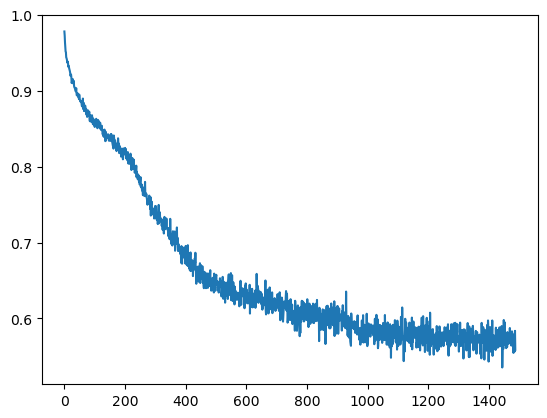

In [56]:
# training
N_EPOCHS = 1
N_BATCHES = 100
i_batch = 0
for j in range(N_EPOCHS):
    for i, (x, y) in enumerate(train_loader):
        i_batch += 1
        model.train()
        optimizer.zero_grad()
        with torch.autocast('cuda'):
            prediction = model(x.to(device))
            loss = dice_loss(prediction, y.to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if i_batch%5==0:
            print(i_batch, loss.item())
        losses.append(loss.item())
        if i_batch==N_BATCHES:
            break
    

plt.plot(losses)
plt.show()


In [57]:
torch.save(model, './model.pt')

In [9]:
model = torch.load('./model.pt')

C:\Users\zaits\AppData\Local\Temp\ipykernel_9048\4142937112.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./model.pt')


In [58]:
model.eval()
with torch.no_grad():
    for img, smnt in train_loader:
        output = model(img[:1].cuda())
        break

In [59]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.078431375..1.0177778].


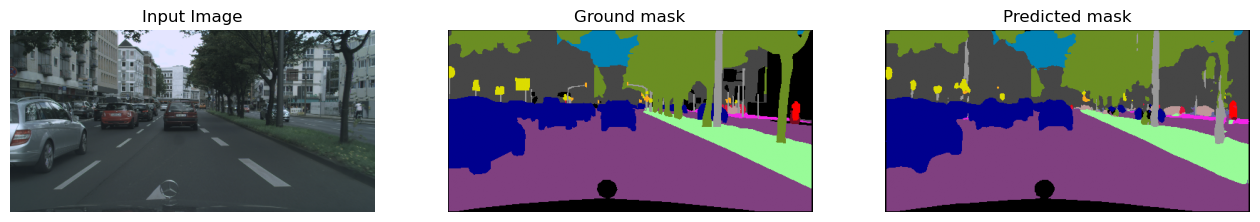

In [60]:
i = 0
invimg = inv_normalize(img[i])
y = output.detach().cpu()[0]
decoded_mask = decode_segmap(smnt[i].clone())  #(256, 512)
decoded_ouput = decode_segmap(torch.argmax(y, 0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
#ax[1].imshow(encoded_mask,cmap='gray') #(256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.show()